# Bayesian modeling for the detection of adverse events underreporting in clinical trials

This is the companion notebook of a paper by Y. Barmaz and T. Ménard on a statistical method for the detection of adverse event underreporting from clinical trial investigator sites.

In [1]:
import pandas as pd
import numpy as np
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

In [2]:
data = pd.read_csv('data.csv')
data.head(5)

,study,site_number,patnum,ae_count_cumulative
0,NCT00617669,3001,16,4
1,NCT00617669,3001,456,1
2,NCT00617669,3002,171,2
3,NCT00617669,3002,248,2
4,NCT00617669,3002,304,1


## Data preparation for the analysis

In [3]:
sites = tf.constant(data['site_number'])
observed_ae = tf.constant(data['ae_count_cumulative'])

unique_sites, sites_idx, sites_counts = tf.unique_with_counts(sites)

ae_per_site = tf.RaggedTensor.from_value_rowids(
    values=observed_ae,
    value_rowids=sites_idx)

In [4]:
df_obs = (data
          .groupby('ae_count_cumulative')[['patnum']]
          .count()
          .reset_index()
          .rename({'patnum': 'observed', 'ae_count_cumulative': 'ae_count'}, axis=1)
          .assign(norm_observed=lambda x: x.observed/x.observed.sum())
         )

df_obs = (pd.DataFrame({'ae_count': range(50)})
          .merge(df_obs.reset_index(drop=True), how='left')
          .fillna(0)
          .assign(observed=lambda x: x.observed.astype(int))
         )

## Frequency of observed adverse event counts per patient

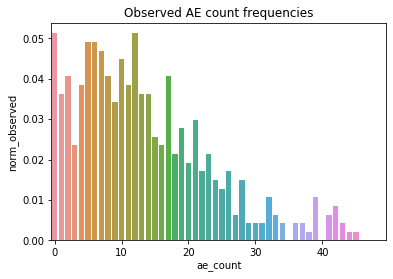

In [5]:
def format_barplot(ax):
    ax.xaxis.set_major_locator(plt.MultipleLocator(10))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick: int(x)))
    return ax
    
ax = format_barplot(sns.barplot(x='ae_count', y='norm_observed', data=df_obs))
ax.set_title('Observed AE count frequencies')
plt.show()

## Model

In [6]:
mdl_ae = tfd.JointDistributionSequential([
    #alpha
    tfd.Gamma(1, 1, name='alpha'),
    #beta
    tfd.Gamma(1, 10, name='beta'),
    #Poisson rates for each sites
    lambda beta, alpha: tfd.Sample(tfd.Gamma(alpha, beta), sample_shape=unique_sites.shape, name='rates'),
    #observed AEs
    lambda rates: tfd.Independent(tfd.Poisson(tf.gather(rates, sites_idx, axis=-1)), reinterpreted_batch_ndims=1, name='observations')
])

In [7]:
mdl_ae.resolve_graph()

(('alpha', ()),
 ('beta', ()),
 ('rates', ('beta', 'alpha')),
 ('observations', ('rates',)))

## Prior predictive check


In [8]:
prior_sample = mdl_ae.sample(100)

In [9]:
ae_values, prior_counts =np.unique(prior_sample[3].numpy().flatten().astype(int), return_counts=True)
df_prior_obs = df_obs.merge(pd.DataFrame({'ae_count': ae_values,
                                          'prior': prior_counts,
                                          'norm_prior': prior_counts/prior_counts.sum()}),
                            how='left')

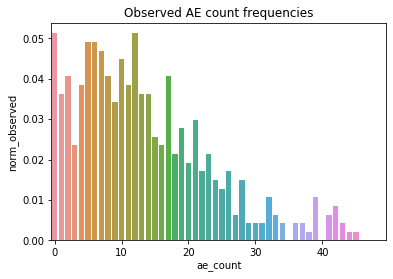

In [10]:
ax = format_barplot(sns.barplot(x='ae_count', y='norm_observed', data=df_prior_obs))
ax.set_title('Observed AE count frequencies')
plt.show()

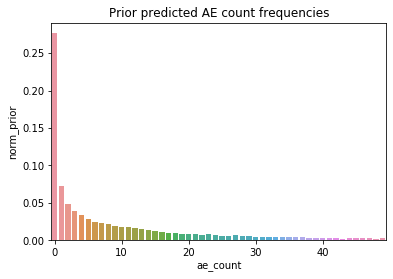

In [11]:
ax = format_barplot(sns.barplot(x='ae_count', y='norm_prior', data=df_prior_obs))
ax.set_title('Prior predicted AE count frequencies')
plt.show()

## HMC algorithm

In [28]:
dtype = tf.dtypes.float32
nchain = 10
burnin=1000
num_steps=10000
alpha0, beta0, rates0, _ = mdl_ae.sample(nchain)
init_state = [alpha0, beta0, rates0]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1, .05]]
target_log_prob_fn = lambda *init_state: mdl_ae.log_prob(
    list(init_state) + [tf.cast(observed_ae, dtype=dtype)])

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Exp(),
    tfb.Exp()
]

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=num_steps, burnin=burnin):
    
    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.is_accepted
               )

    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn,
        num_leapfrog_steps=3,
        step_size=step_size),
      bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=kernel,
      num_adaptation_steps=burnin
    )

    # Sampling from the chain.
    [alpha, beta, rates], is_accepted = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc,
        seed=4321,
        trace_fn=trace_fn)
    return alpha, beta, rates, is_accepted

## Sampling

In [29]:
alpha, beta, rates, is_accepted = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

In [30]:
alpha_ = alpha[burnin:,:]
alpha_ = tf.reshape(alpha_, [alpha_.shape[0]*alpha_.shape[1]])
beta_ = beta[burnin:,:]
beta_ = tf.reshape(beta_, [beta_.shape[0]*beta_.shape[1]])
rates_ = rates[burnin:,:]
rates_ = tf.reshape(rates_, [rates_.shape[0]*rates_.shape[1], rates_.shape[2]])

rates_dist_ = tfd.Gamma(alpha_[:,tf.newaxis], beta_[:, tf.newaxis])
rates_cdf_ = rates_dist_.cdf(rates_)

In [31]:
posterior = {unique_sites.numpy()[i]: np.swapaxes(rates[2*burnin:, :, i].numpy(), 1, 0) for i in range(10)}
posterior['alpha'] = tf.transpose(alpha[2*burnin:, :]).numpy()
posterior['beta'] = tf.transpose(beta[2*burnin:, :]).numpy()

In [32]:
az_trace = az.from_dict(posterior=posterior)

## Convergence assessment

In [33]:
is_accepted.numpy().mean()

0.74489

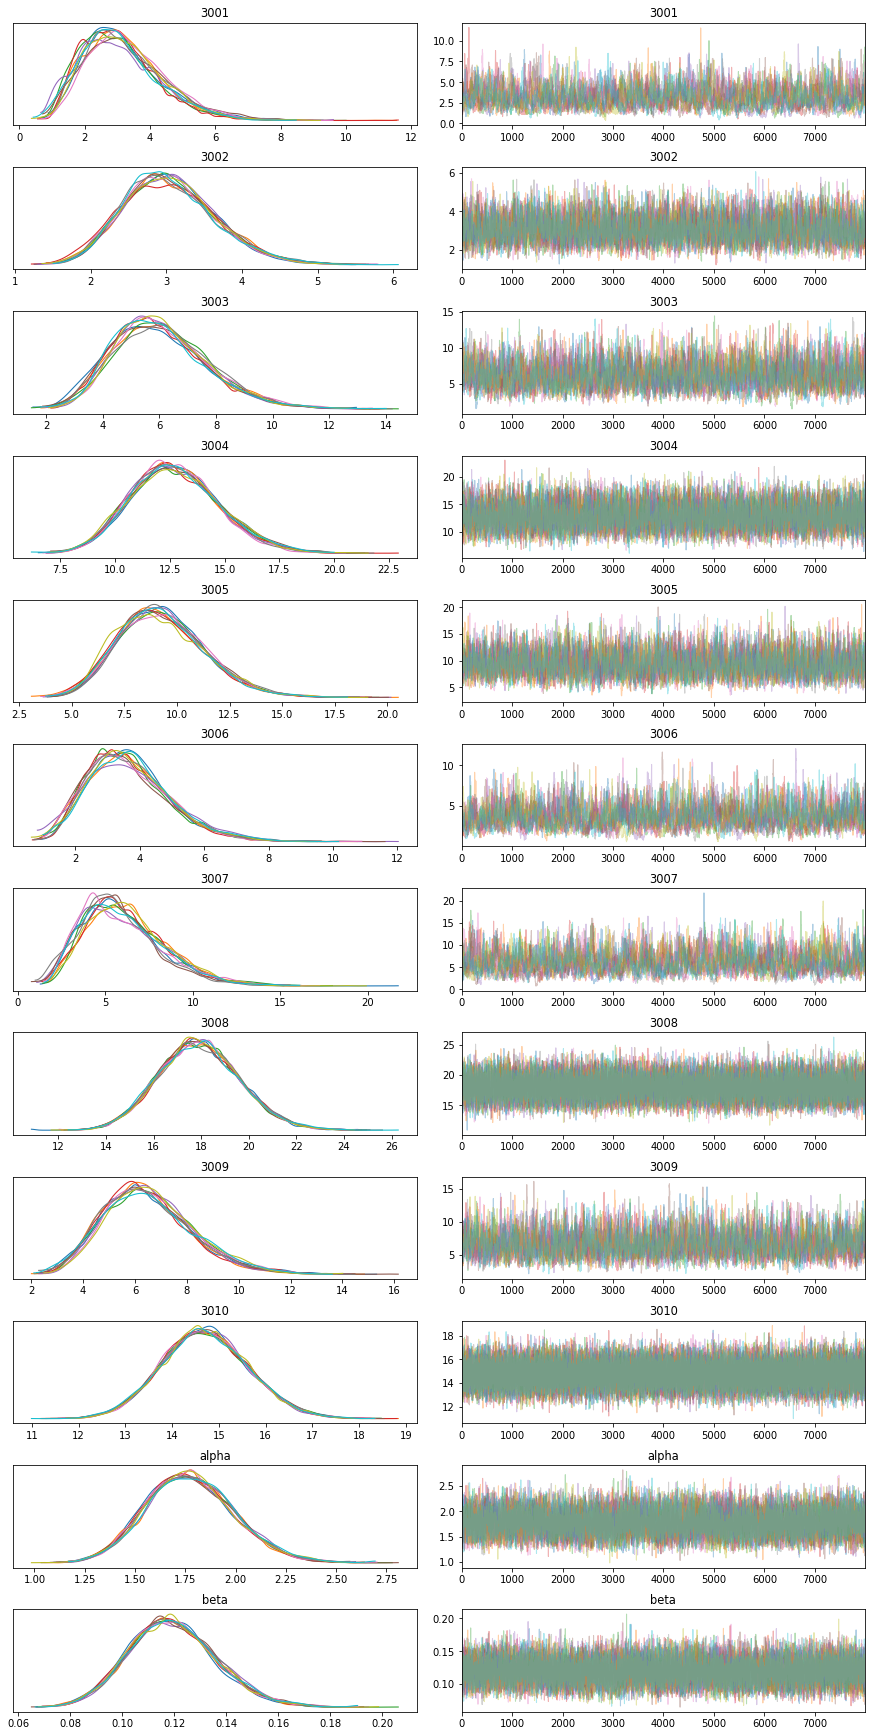

In [34]:
az.plot_trace(az_trace)
plt.show()

In [ ]:
az.summary(az_trace)

In [ ]:
plt.plot(alpha_, beta_, '.')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Joint posterior of alpha and beta')
plt.show()

## Posterior predictive checks

In [ ]:
posterior_predictive_rate = tfd.Gamma(alpha_, beta_).sample().numpy()
ax = sns.displot(posterior_predictive_rate[posterior_predictive_rate<100])
plt.show()

In [ ]:
sns.ecdfplot(posterior_predictive_rate)
plt.show()

In [ ]:
posterior_predictive_ae_sample = tfd.Poisson(rates_).sample()
post_ae_values, posterior_counts =np.unique(posterior_predictive_ae_sample.numpy().flatten().astype(int), return_counts=True)
df_posterior_obs = df_obs.merge(pd.DataFrame({'ae_count': post_ae_values,
                                          'posterior': posterior_counts,
                                          'norm_posterior': posterior_counts/posterior_counts.sum()}),
                            how='left')

In [ ]:
ax = format_barplot(sns.barplot(x='ae_count', y='norm_observed', data=df_posterior_obs))
ax.set_title('Observed AE count frequencies')
plt.show()

In [ ]:
ax = format_barplot(sns.barplot(x='ae_count', y='norm_posterior', data=df_posterior_obs))
ax.set_title('Posterior predicted AE count frequencies')
plt.show()

## Underreporting assessment

In [ ]:
mean_rates = tf.math.reduce_mean(rates_, axis=0)
std_rates = tf.math.reduce_std(rates_, axis=0)
alert = tf.math.reduce_mean(tf.cast(rates_<0.75*posterior_predictive_rate[:,tf.newaxis], tf.float32), axis=0)

tail = tf.math.reduce_mean(tf.cast(rates_>posterior_predictive_rate[:,tf.newaxis], tf.float32), axis=0)

rates_tail = tf.math.reduce_mean(rates_cdf_, axis=0)

summary_df = pd.DataFrame({'site': unique_sites.numpy().astype(np.float).astype(int),
                           'mean_ae_rate': mean_rates.numpy(),
                           'std_ae_rate': std_rates.numpy(),
                           'rate_tail_area': rates_tail.numpy(),
                           #'tail': tail.numpy(),
                           'p75': alert.numpy(),
                           'observed_ae': [obs.numpy() for obs in list(ae_per_site)]
                          }).assign(n_pt=lambda x: x.observed_ae.apply(len)).set_index('site', drop=True)

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
summary_df.sort_values('rate_tail_area', ascending=False)

In [ ]:
sns.scatterplot(x='rate_tail_area', y='p75', data=summary_df)
plt.show()

In [ ]:
ax=sns.scatterplot(x='mean_ae_rate', y='rate_tail_area', data=summary_df)
ax=sns.ecdfplot(posterior_predictive_rate)
ax.set_title('Inferred statistics and posterior predictive CDF')
plt.show()